## CML Wet/Dry classification with neural networks

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**TODO:**
- implement as lightning model with tf-board support?
- why cannot we use cpu for inference (batchnorm gives an error)

### Steps:

1. Load data from NetCDF
2. Train ANN
3. Validate the classification result

In [2]:
! nvidia-smi

Thu Aug  8 20:46:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:68:00.0  On |                  N/A |
| 41%   39C    P8    11W / 280W |    550MiB / 24187MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [65]:
import math
import numpy as np
import xarray as xr
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
import dask.array as da
# visualization
from livelossplot import PlotLosses
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.utils.data as utils

from torch.utils.tensorboard import SummaryWriter, FileWriter



In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [29]:
# settings
window = 180
slide = 60
refmin = 60

bs = 1024
epochs = 30

In [30]:
# file locations
fn_train = '/data/ifu/summerschool/original.datasets/ifu.polz/CML_training_data_summerschool.nc'
fn_validtest  = '/data/ifu/summerschool/original.datasets/ifu.polz/CML_validation_data_summerschool.nc'

In [31]:
def read_cml_data_from_netcdf4_xr(fn):
    with xr.open_dataset(fn) as ds:
        starting_time = ds.time
        mask = ds.samples.min(dim=['x', 'channel']) >= -9000

        print(f'Missing {ds.n_samples.values.size - mask.sum().values} of {ds.n_samples.size}')
        
        ds_good = ds.isel(n_samples=mask)

        wet_samples = int(ds_good.reference.sum().values)
        dry_samples = int(ds_good.reference.size - wet_samples)
        
        print(f'Wet: {wet_samples}, Dry: {dry_samples}, Wet/Dry-Ratio: {(wet_samples/dry_samples)*100:.2f}%')
        
        # downsample dry samples to match wet sample amount
        idx_wet = np.where(ds_good.reference.values == True)[0]
        idx_dry = np.where(ds_good.reference.values == False)[0]

        np.random.seed(42)
        idx_dry_subsample = np.random.choice(idx_dry, idx_wet.size, replace=False, )

        ds_balanced = ds_good.isel(n_samples=np.sort(np.append(idx_wet, idx_dry_subsample)))

    return (ds_balanced.samples.values, ds_balanced.reference.values, ds_balanced.RainRateRadolan.values, ds_balanced.time.values)

#read_cml_data_from_netcdf4_xr('/data/ifu/summerschool/original.datasets/ifu.polz/CML_training_data_summerschool.nc')

# Functions

In [32]:

########################
## Plotting utilities ##
########################


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def Roc_curve(y_pred, y_test):
    roc = []
    for i in tqdm(range(0,1001,1)):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)
        true_pos = np.sum(np.logical_and(y_test==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_test==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_test==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_test==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/(cond_pos+EPSILON),
                    false_pos/(cond_neg+EPSILON)])
    roc.append([0,0])
    
    return np.array(roc)

def roc_surface(roc):
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

###################
## Keras Metrics ##
###################

def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

EPSILON = 1e-7

def matthews_correlation_pytorch(y_pred, y_true):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    
    
    y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = torch.round(torch.clamp(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = torch.sum(y_pos * y_pred_pos)
    tn = torch.sum(y_neg * y_pred_neg)

    fp = torch.sum(y_neg * y_pred_pos)
    fn = torch.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + EPSILON)

def meansquarederror(y_pred, y_true):
    return ((y_pred-y_true)**2).mean()


def matthews_correlation_binary(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos

    y_pos = y_true
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def cwet_rwet(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)/K.sum(y_pos)
    return tp

def cdry_rdry(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)/K.sum(y_neg)
    return tn

def cwet_rdry(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    fp = K.sum(y_neg * y_pred_pos)/K.sum(y_neg)
    return fp

def cdry_rwet(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    fn = K.sum(y_pos * y_pred_neg)/K.sum(y_pos)
    return fn

# Load data

In [33]:
X_train, y_train, rainratetrain, starting_time_train = read_cml_data_from_netcdf4_xr(fn_train)
X_validtest,  y_validtest,  rainratevalidtest,  starting_time_validtest  = read_cml_data_from_netcdf4_xr(fn_validtest)

# eliminiate small rain events
rainratetrain[rainratetrain<0.1]=0
rainratevalidtest[rainratevalidtest<0.1]=0

# shuffle training data
X_train, y_train, rainratetrain, starting_time_train = shuffle(X_train, y_train, rainratetrain, starting_time_train)

from sklearn.model_selection import train_test_split
X_valid, X_test, y_valid, y_test, rainratevalid, rainratetest, starting_time_valid, starting_time_test = train_test_split(X_validtest, y_validtest, rainratevalidtest, starting_time_validtest, test_size = 0.6, random_state = seed)

Missing 17234 of 146200
Wet: 6347, Dry: 122619, Wet/Dry-Ratio: 5.18%
Missing 38756 of 222600
Wet: 6530, Dry: 177314, Wet/Dry-Ratio: 3.68%


# test the lightning module (remove)

In [8]:
import os
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import pytorch_lightning as pl

class CoolModel(pl.LightningModule):

    def __init__(self):
        super(CoolModel, self).__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def my_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': self.my_loss(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.my_loss(y_hat, y)}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        return [torch.optim.Adam(self.parameters(), lr=0.02)]

    @pl.data_loader
    def tng_dataloader(self):
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    @pl.data_loader
    def test_dataloader(self):
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

In [9]:
cmodel = CoolModel()
cmodel

CoolModel(
  (l1): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
import os
from pytorch_lightning import Trainer
from test_tube import Experiment, HyperOptArgumentParser

#args = HyperOptArgumentParser()
#hparams = args.parse_args()

log_dir = '/scratch'
exp = Experiment(
    name='test_tube_exp',
    debug=True,
    save_dir=log_dir,
    version=0,
    autosave=False,
    description='test demo 1'
)
# set the hparams for the experiment
#exp.argparse(hparams)
exp.save()

trainer = Trainer(experiment=exp, max_nb_epochs=5, train_percent_check=0.5, add_log_row_interval=2)
trainer.fit(cmodel)

  2%|▏         | 49/2812 [00:00<00:10, 271.97it/s, batch_nb=48, epoch=0, tng_loss=0.803, v_nb=0]

gpu available: True, used: False
  Name    Type  Params
0   l1  Linear    7850


2813it [00:06, 424.48it/s, avg_val_loss=0.877, batch_nb=937, epoch=2, tng_loss=0.760, v_nb=0]                          
2813it [00:06, 474.51it/s, avg_val_loss=0.867, batch_nb=937, epoch=4, tng_loss=0.767, v_nb=0]                          

1

2813it [00:26, 474.51it/s, avg_val_loss=0.867, batch_nb=937, epoch=4, tng_loss=0.767, v_nb=0]

In [64]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter, FileWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter(log_dir='/scratch/test2')

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

In [34]:
class CmlCNN(nn.Module):
    def __init__(self):
        super(CmlCNN, self).__init__()
        self.bnor1 = nn.BatchNorm1d(num_features=2, eps=0.001)
        
        # kernel size modded to achieve same output size
        self.conv1 = nn.Conv1d(2, 24, kernel_size=9, padding=4, bias=False)
        self.maxp1 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor2 = nn.BatchNorm1d(num_features=24, eps=0.001)
        self.conv2 = nn.Conv1d(24, 48, kernel_size=5, padding=2, bias=False)
        self.maxp2 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor3 = nn.BatchNorm1d(num_features=48, eps=0.001)
        self.conv3 = nn.Conv1d(48, 48, kernel_size=5, padding=2, bias=False)
        self.maxp3 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor4 = nn.BatchNorm1d(num_features=48, eps=0.001)
        self.conv4 = nn.Conv1d(48, 96, kernel_size=5, padding=2, bias=False)
        self.maxp4 = nn.MaxPool1d(kernel_size=3)

        self.bnor5 = nn.BatchNorm1d(num_features=96, eps=0.001)
        self.conv5 = nn.Conv1d(96, 192, kernel_size=1, bias=False)
        
        self.gavgp = nn.AdaptiveAvgPool1d(1)
        
        self.dens1 = nn.Linear(192, 64)
        self.drop1 = nn.Dropout(0.4)
        self.dens2 = nn.Linear(64, 64)
        self.drop2 = nn.Dropout(0.4)
        self.dens3 = nn.Linear(64, 1)

        
    def forward(self, x):
        x = self.bnor1(x)
        x = self.maxp1(F.relu(self.conv1(x)))

        x = self.bnor2(x)
        x = self.maxp2(F.relu(self.conv2(x)))

        x = self.bnor3(x)
        x = self.maxp3(F.relu(self.conv3(x)))

        x = self.bnor4(x)
        x = self.maxp4(F.relu(self.conv4(x)))

        x = self.bnor5(x)
        x = self.gavgp(F.relu(self.conv5(x))).squeeze()

        x = self.drop1(F.relu(self.dens1(x)))
        x = self.drop2(F.relu(self.dens2(x)))
        return torch.sigmoid(self.dens3(x)).squeeze()

In [35]:
from torchsummary import summary
model = CmlCNN().to(device)
summary(model, input_size=(2, window))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1               [-1, 2, 180]               4
            Conv1d-2              [-1, 24, 180]             432
         MaxPool1d-3               [-1, 24, 60]               0
       BatchNorm1d-4               [-1, 24, 60]              48
            Conv1d-5               [-1, 48, 60]           5,760
         MaxPool1d-6               [-1, 48, 20]               0
       BatchNorm1d-7               [-1, 48, 20]              96
            Conv1d-8               [-1, 48, 20]          11,520
         MaxPool1d-9                [-1, 48, 6]               0
      BatchNorm1d-10                [-1, 48, 6]              96
           Conv1d-11                [-1, 96, 6]          23,040
        MaxPool1d-12                [-1, 96, 2]               0
      BatchNorm1d-13                [-1, 96, 2]             192
           Conv1d-14               [-1,

In [36]:
# data loaders
train_data = utils.TensorDataset(torch.Tensor(X_train).permute(0,2,1), 
                                 torch.Tensor(y_train),
                                 torch.Tensor(rainratetrain))
valid_data  = utils.TensorDataset(torch.Tensor(X_valid).permute(0,2,1),
                                  torch.Tensor(y_valid),
                                  torch.Tensor(rainratevalid))
test_data  = utils.TensorDataset(torch.Tensor(X_test).permute(0,2,1),
                                 torch.Tensor(y_test),
                                 torch.Tensor(rainratetest))

train_loader = DataLoader(train_data, batch_size=bs,
                          shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=bs,
                          num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=bs,
                          num_workers=4, pin_memory=True)

data_loader = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# Training

In [99]:
def train_model(model, criterion, optimizer, writer, num_epochs=30):
    liveloss = PlotLosses()
    model = model.to(device)
    bcnt = 0
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_mse = 0.0
            running_mattews_cor = 0.0
            
            bcnt = 0
            for inputs, labels, _ in data_loader[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                preds = torch.round(outputs)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) #* inputs.size(0)

                running_mse += meansquarederror(preds, labels) * inputs.size(0)
                running_mattews_cor += matthews_correlation_pytorch(preds, labels)* inputs.size(0)
                writer.add_scalar(f'{phase}/Loss', loss.detach(), (epoch * len(data_loader[phase]))+bcnt)
                #writer.add_scalar(f'{phase}/Acc', torch.sum(preds == labels.data)/inputs.size(0), (epoch * len(data_loader[phase]))+bcnt)
            
                bcnt += 1
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.float() / len(data_loader[phase].dataset)
            epoch_mse = running_mse / len(data_loader[phase].dataset)
            epoch_matthews_cor = running_mattews_cor / len(data_loader[phase].dataset)

            prefix = 'val_' if phase == 'valid' else ''

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
            logs[prefix + 'mse']      = epoch_mse.item()
            logs[prefix + 'matthews_correlation']  = epoch_matthews_cor.item()

            writer.add_scalar(f'{phase}/Loss Epoch', epoch_loss.item(), epoch)
            writer.add_scalar(f'{phase}/Acc Epoch', epoch_acc.item(), epoch)
            writer.add_scalar(f'{phase}/MSE Epoch', epoch_mse.item(), epoch)
            writer.add_scalar(f'{phase}/Matthews Cor Epoch', epoch_matthews_cor.item(), epoch)

       
            
        #writer.add_scalars('Perf/Loss', dict((k, logs[k]) for k in ('log loss', 'val_log loss')), epoch)
        #writer.add_scalars('Perf/Acc', dict((k, logs[k]) for k in ('accuracy', 'val_accuracy')), epoch)
        #writer.add_scalars('Extra/MSE', dict((k, logs[k]) for k in ('mse', 'val_mse')), epoch)
        #writer.add_scalars('Extra/Matthews', dict((k, logs[k]) for k in ('matthews_correlation', 'val_matthews_correlation')), epoch)
        
        #writer.add_graph(model, inputs)
        
        liveloss.update(logs)
        
        liveloss.draw()
  

In [100]:
model = CmlCNN()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.005, 
                      weight_decay=1e-5, 
                      momentum=0.9, 
                      nesterov=True)

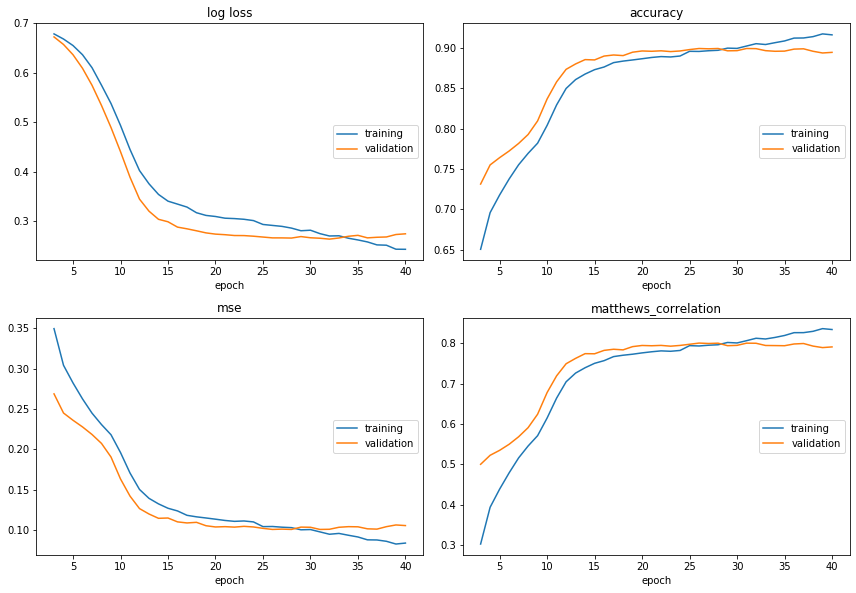

log loss:
training   (min:    0.244, max:    0.694, cur:    0.244)
validation (min:    0.264, max:    0.691, cur:    0.275)

accuracy:
training   (min:    0.509, max:    0.918, cur:    0.916)
validation (min:    0.551, max:    0.900, cur:    0.895)

mse:
training   (min:    0.082, max:    0.491, cur:    0.084)
validation (min:    0.100, max:    0.449, cur:    0.105)

matthews_correlation:
training   (min:    0.018, max:    0.836, cur:    0.834)
validation (min:    0.205, max:    0.800, cur:    0.791)
CPU times: user 56.5 s, sys: 54.9 s, total: 1min 51s
Wall time: 1min 16s


In [101]:
%%time
import datetime
ID = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = f"/scratch/{ID}"
os.makedirs(logdir)

writer = SummaryWriter(logdir)    
    
train_model(model, criterion, optimizer, writer, num_epochs=40)

writer.close()

In [270]:
# Write the model model's state_dict
torch.save(model.state_dict(), 'CmlCNN.pth')

In [368]:
# load the model from disk
model = CmlCNN()
model.load_state_dict(torch.load('CmlCNN.pth'))
model.to(device)
model.eval()

# final test of the model
for phase in ['train', 'valid', 'test']:
    model.eval()

    y_Pred_t  = []
    y_Test    = []
    rainrates = []
    
    running_corrects = 0
    for inputs, labels, rrates in data_loader[phase]:
        y_Test += labels.tolist()
        
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        y_Pred_t += outputs.tolist()
        rainrates += rrates.tolist()
        
        running_corrects += torch.sum(outputs.round() == labels.data) #* inputs.size(0)

    acc = (running_corrects.float() / len(data_loader[phase].dataset)).cpu().numpy()
    print( f"{phase.capitalize()+' accuracy':14} {(acc*100):.1f}%" )

Train accuracy 91.1%
Valid accuracy 90.3%
Test accuracy  90.2%


In [369]:
y_Pred_t = np.array(y_Pred_t)
y_Test   = np.array(y_Test)
rainrates = np.array(rainrates)  

 Best matthews correlation at a threshold of  0.37  with a score of  0.809 
 Best accuracy at a threshold of  0.37  with a score of  0.904


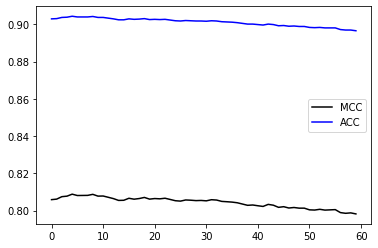

In [298]:
perf_thresh=[]
for i in range(350,650,5):
    t=i/1000
    y_temp1 = y_Pred_t>t
    perf_thresh.append([matthews_corrcoef(y_Test, y_temp1),
                        accuracy_score(y_Test, y_temp1)])

perf_thresh=np.array(perf_thresh)
    
threshold_mcc = (list(perf_thresh[:,0]).index(np.max(perf_thresh[:,0]))*5+350)/1000
threshold_acc = (list(perf_thresh[:,1]).index(np.max(perf_thresh[:,1]))*5+350)/1000

print(' Best matthews correlation at a threshold of ', threshold_mcc,' with a score of ', np.round(np.max(perf_thresh[:,0]), decimals=3),'\n', 
      'Best accuracy at a threshold of ',threshold_acc, ' with a score of ',np.round(np.max(perf_thresh[:,1]), decimals=3))
plt.plot(perf_thresh[:,0], 'k-', label='MCC')
plt.plot(perf_thresh[:,1], 'b-', label='ACC')
plt.legend()
plt.show()

MCC: 0.8088359000919321
ACC: 0.9042879019908117
F1: 0.9043855175930648


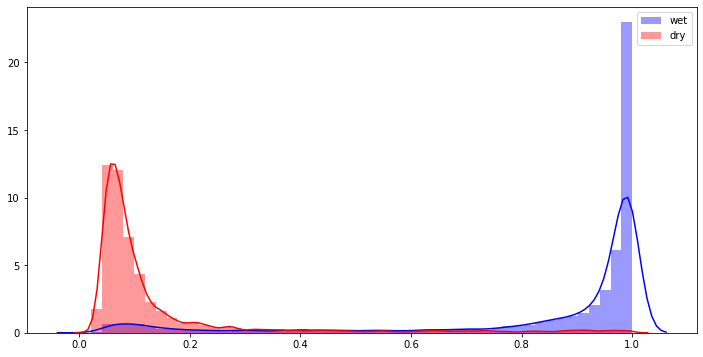

In [328]:
fig = plt.figure(figsize=(12,6))
sns.distplot(y_Pred_t[np.array(y_Test)==1], color='b', label='wet')
sns.distplot(y_Pred_t[np.array(y_Test)==0], color='r', label='dry')
plt.legend()

print('MCC:', matthews_corrcoef(y_Test, np.ravel(y_Pred_t)>threshold_mcc))
print('ACC:', accuracy_score(y_Test, np.ravel(y_Pred_t)>threshold_mcc))
print('F1:', f1_score(y_Test, np.ravel(y_Pred_t)>threshold_mcc))

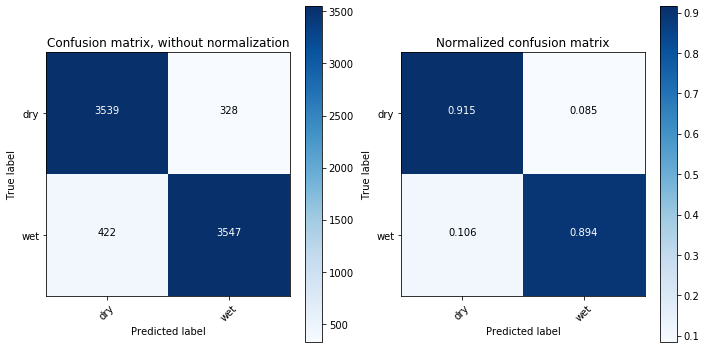

In [329]:
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_Test, np.ravel(y_Pred_t)>threshold_mcc)
np.set_printoptions(precision=3)
class_names = ['dry','wet']

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.add_subplot(122)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [366]:
roc = Roc_curve(np.array(y_Pred_t), np.array(y_Test))

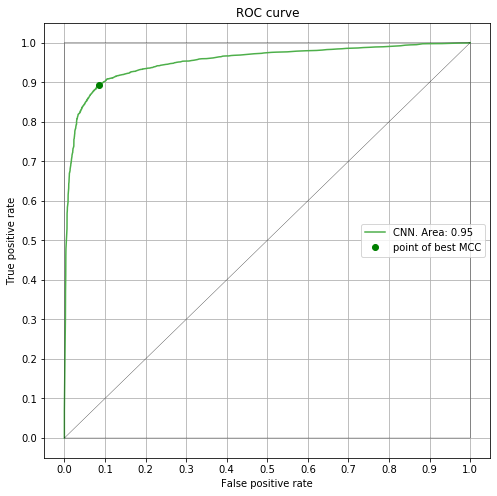

In [367]:
plt.figure(figsize=(8,8))

plt.plot(roc[:,1],roc[:,0], color='#4daf4a', label='CNN. Area: '+str(np.round(roc_surface(roc), decimals=2)))
plt.plot(roc[int(threshold_mcc*1000),1],roc[int(threshold_mcc*1000),0], 'go', label='point of best MCC')

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='center right', ncol=1)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [373]:
def scores_on_rainrates(y_test, y_pred, rainratetest):
    scores_on_rainrates = []
    scores_on_rainrates.append([0, accuracy_score(y_test[rainratetest==0], y_pred[rainratetest==0])])
    for i in range(0,15,1):
        scores_on_rainrates.append([(i+1)/10, accuracy_score(y_test[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+1)/10)], 
                                                             y_pred[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+1)/10)])])
    scores_on_rainrates.append([1.6, accuracy_score(y_test[rainratetest>1.5], y_pred[rainratetest>1.5])])
    scores_on_rainrates = np.array(scores_on_rainrates)
    
    return scores_on_rainrates

In [378]:
scores_per_rrate = scores_on_rainrates(y_Test, 
                                       np.ravel(y_Pred_t)>threshold_mcc,
                                       rainrates)

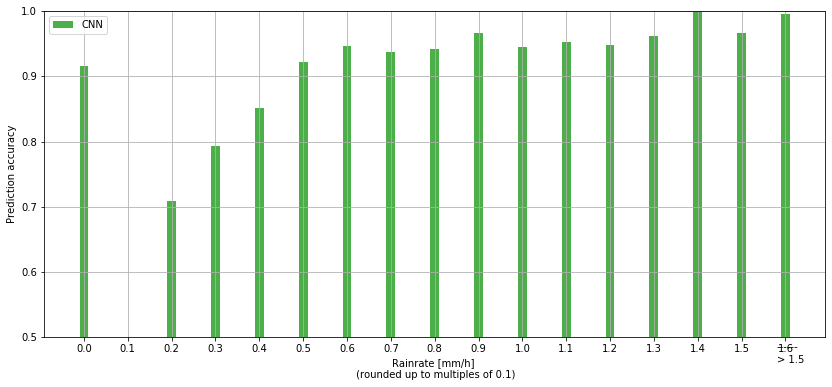

In [380]:
plt.figure(figsize=(14,6))
plt.bar(scores_per_rrate[:,0],scores_per_rrate[:,1], color='#4daf4a', width=0.02, label='CNN')
plt.xticks(np.arange(0, 1.7, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0.5, 1.)
plt.ylabel('Prediction accuracy')
plt.xlabel('Rainrate [mm/h] \n (rounded up to multiples of 0.1)')
plt.legend(loc='upper left')
plt.text(1.58,0.48,'------')
plt.text(1.58,0.46,'> 1.5')
plt.title('')
plt.grid()
plt.show()